In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darkdev007
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:11<00:00, 65.8MB/s]


In [65]:
import torch
from torch import nn
import torchvision
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
from pathlib import Path
dataset_path = Path("/content/animal-faces/afhq")
train_dir = dataset_path /"train"
val_dir = dataset_path / "val"
train_dir, val_dir

(PosixPath('/content/animal-faces/afhq/train'),
 PosixPath('/content/animal-faces/afhq/val'))

In [22]:
#View some images
#get a list of the training images
os.listdir(train_dir)
list_of_training_data_images = list(Path(train_dir).glob("*/*.jpg"))
list_of_validation_data_images = list(Path(val_dir).glob("*/*.jpg"))
len(list_of_training_data_images), len(list_of_validation_data_images)

(14630, 1500)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

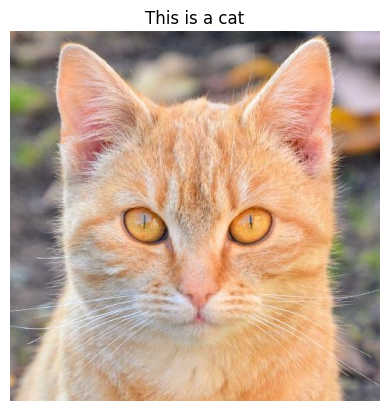

In [29]:
import random
random_choice = random.choice(list_of_training_data_images)
random_image = Image.open(random_choice)
name_of_image = random_choice.parent.stem
plt.imshow(random_image)
plt.title(f"This is a {name_of_image}")
plt.axis(False)

In [35]:
def class_names(list_path):
  return os.listdir(list_path)



In [36]:
class_names(train_dir)

['wild', 'dog', 'cat']

In [49]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = Path(root_dir)
    self.transform = transform

    #get all image file paths
    self.image_paths = list(self.root_dir.glob("*/*.jpg"))

    #extrat tlabels from folder names
    self.labels = [p.parent.stem for p in self.image_paths]

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    label = self.labels[idx]

    image = Image.open(image_path).convert("RGB")
    if self.transform:
      image = self.transform(image)

    return image, label



In [39]:
#create transforms
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((288,288)),
    transforms.ToTensor(),
    transforms.transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor()
])

In [50]:
#get train and val datasets
train_dataset = ImageDataset(root_dir = train_dir, transform = train_transform)
validation_dataset = ImageDataset(root_dir = val_dir, transform = val_transform)

In [52]:
#Create dataloaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size = 32,
                              shuffle = True,
                              num_workers=2)

val_dataloader = DataLoader(dataset=validation_dataset,
                              batch_size = 32,
                              num_workers=2)

In [64]:
X,y = next(iter(train_dataloader))
X[0], y[0]

(tensor([[[ 1.9064,  1.8893,  1.9064,  ...,  2.1119,  1.7694,  0.5707],
          [ 1.9407,  1.9064,  1.8550,  ...,  1.8722,  1.8037,  0.5536],
          [ 1.9920,  1.8893,  1.7865,  ...,  1.5810,  1.9920,  0.9646],
          ...,
          [ 1.3755,  1.1872,  1.0331,  ..., -1.8953, -1.6042, -1.0048],
          [ 1.5297,  1.2899,  1.1015,  ..., -1.8610, -1.7412, -1.2788],
          [ 1.6324,  1.5125,  1.3927,  ..., -1.8097, -1.8097, -1.4500]],
 
         [[ 1.3957,  1.3606,  1.3957,  ...,  1.6057,  1.2031, -0.0399],
          [ 1.4482,  1.3957,  1.3431,  ...,  1.3957,  1.2906,  0.0126],
          [ 1.5182,  1.3957,  1.2731,  ...,  1.0980,  1.5357,  0.4853],
          ...,
          [ 1.9384,  1.8158,  1.6933,  ..., -1.9832, -1.6856, -1.0553],
          [ 2.0434,  1.8508,  1.7108,  ..., -1.9482, -1.7906, -1.2829],
          [ 2.0609,  2.0084,  1.9209,  ..., -1.8782, -1.8606, -1.4405]],
 
         [[ 1.1585,  1.1062,  1.1062,  ...,  0.6356,  0.6356, -0.3404],
          [ 1.2108,  1.1411,

In [66]:
#get your model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT


In [68]:
weights.transforms()

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [69]:
model = torchvision.models.efficientnet_b2(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 118MB/s]


In [70]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [71]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [74]:
for params in model.parameters():
  params.requires_grad=False

In [75]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True ),
    nn.Linear(in_features=1408, out_features=3)
)

In [78]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [76]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=1e-3)

In [ ]:
#create a training loop
from tqdm.auto import tqdm
EPOCH = 5
for epoch in tqdm(range(EPOCH)):
  model.train()

  train_loss, train_acc = 0 ,0
  for X,y in train_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_prob = torch.softmax(y_pred, dim=1)
    y_pred_class = torch.argmax(y_pred_prob, dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(train_dataloader)
  train_acc = train_acc/len(train_dataloader)






